In [1]:
!pip install plotly --upgrade

Requirement already up-to-date: plotly in c:\anaconda\lib\site-packages (3.9.0)


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# imports and settings for plots
from matplotlib import pyplot
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr 
import plotly.plotly as py
import plotly.tools as tls
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARIMA

# need tf backend as background
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [3]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(18,9)})

#### Задача:
1. Воспроизведите график числа рекламных событий по дням. 
2. Найдите причину резкого увеличения количества рекламных событий и объясните, что произошло. 
3. Предложите способ, который помог бы автоматически детектировать аномальные изменения метрик на графиках рекламной статистики. 
Иными словами, предложите алгоритм, который каждое утро анализирует данные за прошедшие сутки, и, если они сильно выбиваются из общего тренда, отправляет аналитику уведомление: на этом графике есть проблема за вчерашний день. 
Подумайте, как сделать детектор, который проверяет на аномалии каждый час, каждые пять минут в графике? 

Предложите вариант кода, который решает эту задачу. Реализовывать логику нотификации не нужно, только поиск аномального дня, часа, пятиминутки в данных рекламной статистики. 

Немного дополнительной информации о структуре рекламы ВКонтакте. 
Есть две основные группы рекламодателей: агентства и клиенты. 
Агентствами являются рекламные кабинеты юридических лиц. Среди клиентов же существуют как клиенты этих самых агентств, так и автономные рекламные кабинеты физических лиц, над которыми нет агентств. 
Рекламные кампании — это наборы рекламных объявлений. 
Они есть в каждом кабинете. 

Описание данных:

- time — время взаимодействия пользователя с рекламой в формате UnixTime;
- event — тип взаимодействия (click — клик на объявление, view — показ объявления, report — жалоба на объявление);
- ad_cost_type — тип трат рекламного объявления (CPM — траты за 1000 показов, CPC — траты за клик);
- has_video — наличие видео в объявлении (0 — нет, 1 — есть);
- agency_union_id — id рекламного агентства (если рекламный кабинет принадлежит физическому лицу, то ячейка будет заполнена значением 'no_agency');
- client_union_id — id рекламного клиента;
- campaign_union_id — id рекламной кампании;
- ad_id — id рекламного объявления;
- platform — платформа, с которой пользователь взаимодействовал с рекламой (web — веб-версия, mvk — мобильная версия, iphone — IOS-приложение, android — Android-приложение, wphone — Windows Phone-приложение).

#### Read data

Считаем первые n-строк, чтобы не загружать весь датасет в память целиком, посмотрим на данные и выберем нужные параметры для считывания.

In [4]:
path = 'data/vk_test_data.csv'
df = pd.read_csv(path, 
                 nrows = 5)

In [5]:
df

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date
0,1.554744e+09,report,CPM,0,no_agency,client_21074,campaign_27489,ad_27489,android,2019-04-08
1,1.555103e+09,click,CPM,0,no_agency,client_22392,campaign_35893,ad_35893,android,2019-04-12
2,1.555403e+09,click,CPM,0,no_agency,client_16836,campaign_26799,ad_26804,web,2019-04-16
3,1.554822e+09,click,CPM,0,no_agency,client_22920,campaign_37146,ad_37146,android,2019-04-09
4,1.554967e+09,click,CPM,0,no_agency,client_645,campaign_15893,ad_15944,web,2019-04-11


Сразу определим типы для time и has_video.

In [6]:
df = pd.read_csv(path, 
                 sep=",",
                 dtype={'time': 'uint32',
                        'has_video': 'bool'})

df['time_from_timestamp'] = pd.to_datetime(df.time,unit='s')

In [7]:
'''
# auxilary method, to check if value is in range
vals = [1554744145, np.int32(2), np.int64(1), np.float64(0)]
[(e, type(e), isinstance(e, (int, np.integer))) for e in vals]
''';

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122097 entries, 0 to 122096
Data columns (total 11 columns):
time                   122097 non-null uint32
event                  122097 non-null object
ad_cost_type           122097 non-null object
has_video              122097 non-null bool
agency_union_id        122097 non-null object
client_union_id        122097 non-null object
campaign_union_id      122097 non-null object
ad_id                  122097 non-null object
platform               122097 non-null object
date                   122097 non-null object
time_from_timestamp    122097 non-null datetime64[ns]
dtypes: bool(1), datetime64[ns](1), object(8), uint32(1)
memory usage: 9.0+ MB


In [9]:
df.head(10)

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,time_from_timestamp
0,1554744145,report,CPM,False,no_agency,client_21074,campaign_27489,ad_27489,android,2019-04-08,2019-04-08 17:22:25
1,1555103458,click,CPM,False,no_agency,client_22392,campaign_35893,ad_35893,android,2019-04-12,2019-04-12 21:10:58
2,1555402601,click,CPM,False,no_agency,client_16836,campaign_26799,ad_26804,web,2019-04-16,2019-04-16 08:16:41
3,1554822479,click,CPM,False,no_agency,client_22920,campaign_37146,ad_37146,android,2019-04-09,2019-04-09 15:07:59
4,1554966717,click,CPM,False,no_agency,client_645,campaign_15893,ad_15944,web,2019-04-11,2019-04-11 07:11:57
5,1555418913,view,CPC,False,no_agency,client_265,campaign_13516,ad_13517,android,2019-04-16,2019-04-16 12:48:33
6,1555146351,report,CPM,False,no_agency,client_22021,campaign_34637,ad_34651,mvk,2019-04-13,2019-04-13 09:05:51
7,1554503043,view,CPM,False,agency_155,client_105617,campaign_106015,ad_106015,iphone,2019-04-05,2019-04-05 22:24:03
8,1554940634,view,CPM,False,no_agency,client_264,campaign_13491,ad_13513,android,2019-04-10,2019-04-10 23:57:14
9,1554719466,view,CPM,False,no_agency,client_1728,campaign_19254,ad_19255,android,2019-04-08,2019-04-08 10:31:06


#### Lineplot

Повторим график из задания, для этого сгруппируем записи по дням и посчитаем количество событий.

In [10]:
count_adv_by_day = df.groupby('date', as_index=False).\
agg({'event':'count'})\
.rename(columns = {'event':'event_count'})\

# need it for correct usage of date formatter in plot
count_adv_by_day['date'] = pd.to_datetime(count_adv_by_day.date, format='%Y-%m-%d')

count_adv_by_day.sort_values(by = 'date', ascending=True, inplace=True)

In [11]:
count_adv_by_day

,date,event_count
0,2019-04-01,5172
1,2019-04-02,5269
2,2019-04-03,5357
3,2019-04-04,5108
4,2019-04-05,5305
5,2019-04-06,3955
6,2019-04-07,4091
7,2019-04-08,8902
8,2019-04-09,7963
9,2019-04-10,7098


In [12]:
# custom formatter for y-axis on plot
def y_fmt(tick_val, pos):
    if tick_val > 1000000:
        val = int(tick_val)/1000000
        return (str(val) + "M")
    elif tick_val > 1000:
        val = int(int(tick_val) / 1000)
        return (str(val) + "k")
    else:
        return tick_val

yfmt = tkr.FuncFormatter(y_fmt)

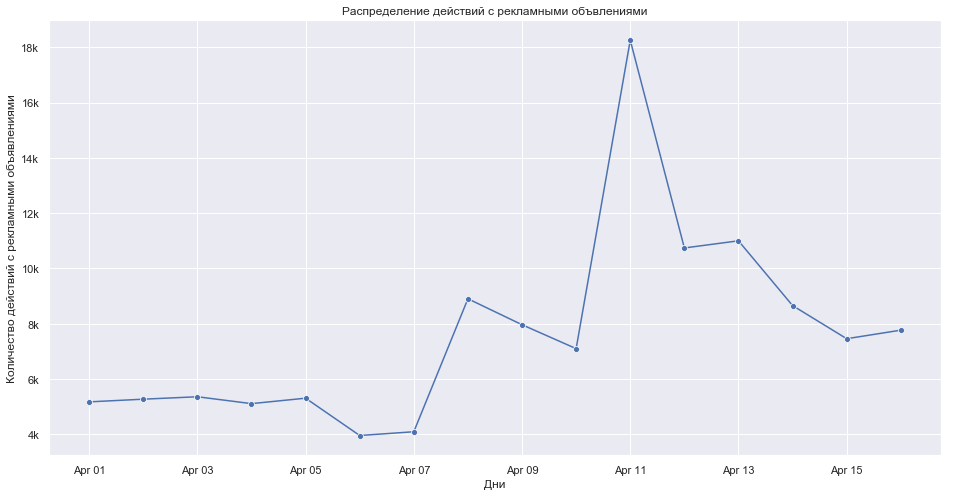

In [13]:
ax = sns.lineplot(x = 'date', 
                  y = 'event_count', 
                  marker="o",
                  data = count_adv_by_day)

ax.figure.set_size_inches(16, 8)
ax.set_title('Распределение действий с рекламными объвлениями')
ax.set_xlabel('Дни')
ax.set_ylabel('Количество действий с рекламными объявлениями')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.yaxis.set_major_formatter(yfmt);

На графике явно виден рост количества событий, который начинается 10 апреля и заканчивается 12 апрелем.

#### Splash reasons?

Причин такого всплеска может быть несколько, в первую очередь это может быть какой-либо технический сбой, затем это может быть какая-либо рекламная акция или же какое-либо произошедшее массовое событие.

Попробуем сначала посмотреть на пропуски и наличие дубликатов, а затем проанализировать каких платформ это коснулось больше всего.

In [14]:
# check for NAs for safety
df.isna().sum()

time                   0
event                  0
ad_cost_type           0
has_video              0
agency_union_id        0
client_union_id        0
campaign_union_id      0
ad_id                  0
platform               0
date                   0
time_from_timestamp    0
dtype: int64

#### Duplicates check.
Проверим исходный набор данных на дубликаты.

In [15]:
df_duplicates = df[df.duplicated(subset = ['time','platform'], keep = False)]
df_duplicates.head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,time_from_timestamp
3,1554822479,click,CPM,False,no_agency,client_22920,campaign_37146,ad_37146,android,2019-04-09,2019-04-09 15:07:59
19,1555011001,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 19:30:01
22,1554977283,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 10:08:03
32,1554152264,view,CPC,False,agency_33,client_99583,campaign_99718,ad_101258,android,2019-04-01,2019-04-01 20:57:44
35,1555173105,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49556,android,2019-04-13,2019-04-13 16:31:45


In [16]:
df_duplicates.shape

(8622, 11)

In [17]:
# drop has video, cause it contains only false
for column in df_duplicates.drop(['time','time_from_timestamp','has_video'], axis = 1):
    #print(column)
    print(df_duplicates[column].value_counts(ascending=False)[:3])

view      6739
click     1539
report     344
Name: event, dtype: int64
CPC    6121
CPM    2501
Name: ad_cost_type, dtype: int64
agency_2      4979
no_agency     2412
agency_158      96
Name: agency_union_id, dtype: int64
client_47270    4840
client_47269      97
client_42         82
Name: client_union_id, dtype: int64
campaign_49554    4840
campaign_47269      83
campaign_5822       59
Name: campaign_union_id, dtype: int64
ad_49554    3122
ad_49556     985
ad_49560     477
Name: ad_id, dtype: int64
android    7901
iphone      359
web         288
Name: platform, dtype: int64
2019-04-11    2900
2019-04-13     994
2019-04-12     835
Name: date, dtype: int64


In [18]:
df_duplicates[df_duplicates.campaign_union_id == 'campaign_49554'].sort_values('time', ascending = True).head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,time_from_timestamp
98771,1554482328,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49564,android,2019-04-05,2019-04-05 16:38:48
20182,1554486863,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49564,android,2019-04-05,2019-04-05 17:54:23
19074,1554487776,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49560,android,2019-04-05,2019-04-05 18:09:36
10110,1554487776,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49560,android,2019-04-05,2019-04-05 18:09:36
9542,1554487776,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49564,android,2019-04-05,2019-04-05 18:09:36


Похоже, что дубликаты есть, но сказать уверенно, что такие записи - дубликаты нельзя, т.к. в исходных данных нет какого-либо уникального идентификатора по каждому событию.

Тем не менее, некоторое количичество повторяющихся событий есть.

Теперь посмотрим на распределение таких признаком как платформа, тип трат и события.

In [19]:
df.head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,time_from_timestamp
0,1554744145,report,CPM,False,no_agency,client_21074,campaign_27489,ad_27489,android,2019-04-08,2019-04-08 17:22:25
1,1555103458,click,CPM,False,no_agency,client_22392,campaign_35893,ad_35893,android,2019-04-12,2019-04-12 21:10:58
2,1555402601,click,CPM,False,no_agency,client_16836,campaign_26799,ad_26804,web,2019-04-16,2019-04-16 08:16:41
3,1554822479,click,CPM,False,no_agency,client_22920,campaign_37146,ad_37146,android,2019-04-09,2019-04-09 15:07:59
4,1554966717,click,CPM,False,no_agency,client_645,campaign_15893,ad_15944,web,2019-04-11,2019-04-11 07:11:57


Определим число вхождений для каждой категории:

In [20]:
for column in df.drop(['time', 'date', 'time_from_timestamp'], axis = 1): 
    print(df[column].value_counts()[:5])

view      87975
click     28639
report     5483
Name: event, dtype: int64
CPC    74202
CPM    47895
Name: ad_cost_type, dtype: int64
False    121429
True        668
Name: has_video, dtype: int64
agency_2      50796
no_agency     47267
agency_33      1813
agency_158     1712
agency_543     1218
Name: agency_union_id, dtype: int64
client_47270     47739
client_47269      2285
client_99583      1732
client_42         1493
client_102753      874
Name: client_union_id, dtype: int64
campaign_49554    47739
campaign_47269     1867
campaign_5822      1012
campaign_387        794
campaign_1181       698
Name: campaign_union_id, dtype: int64
ad_49554    27500
ad_49556     8218
ad_49560     7496
ad_49564     4491
ad_47269     1867
Name: ad_id, dtype: int64
android    83312
iphone     16628
web        14108
mvk         7717
wphone       332
Name: platform, dtype: int64


Для большей наглядности посмотрим в виде графиков на распределение типов трат, платформ и событий.

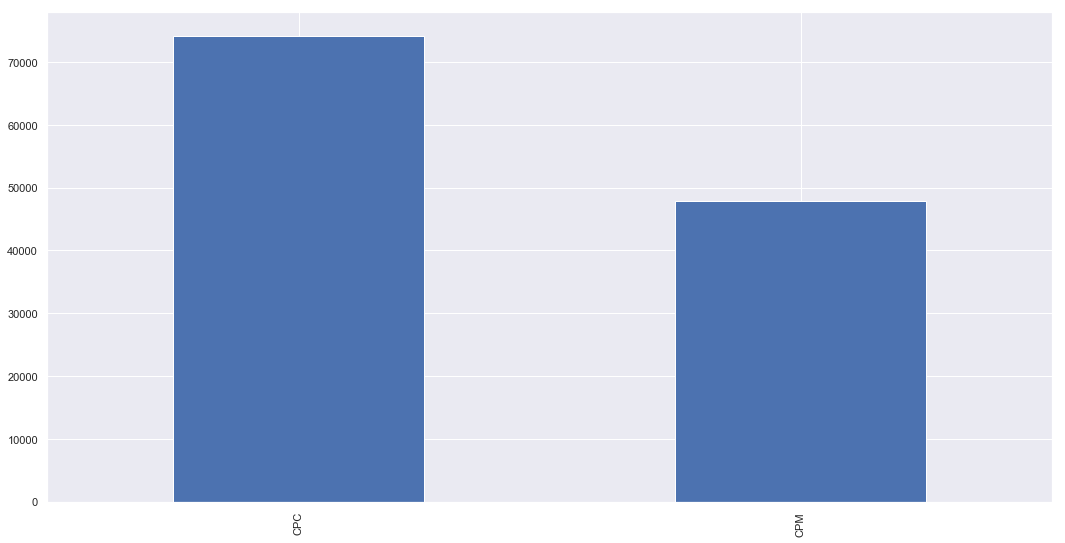

In [21]:
df.ad_cost_type.value_counts().plot(kind='bar')

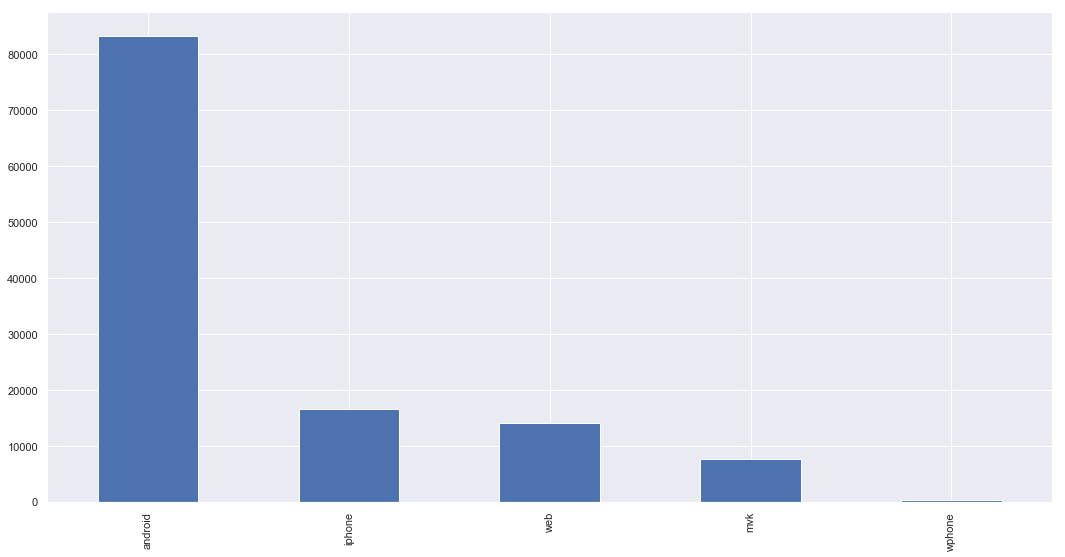

In [22]:
df.platform.value_counts().plot(kind='bar')

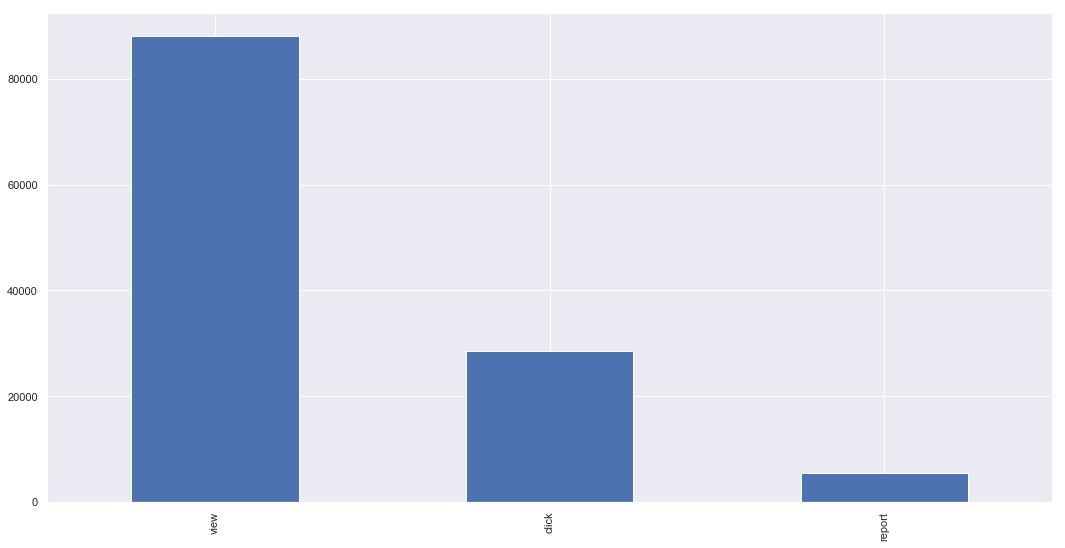

In [23]:
df.event.value_counts().plot(kind='bar')

Пока, из данных видно, что чаще всего происходили события типа view, основной платформой является android, основной тип трат за объявления - за клик. 

Также явно выделяется одна рекламная компания с наибольшим количеством действий по нескольким ad_id.

Посмотрим на данные поближе, а именно как распределяются по дням количество событий, по платформам, по типу трат:

In [24]:
adcost_data = df.pivot_table(index='date',
                                   columns='ad_cost_type',
                                   values='event',
                                   aggfunc='count')

events_data = df.pivot_table(index='date',
                                   columns='event',
                                   values='platform',
                                   aggfunc='count').reset_index()

count_by_platform = df.pivot_table(index='date',
                                   columns='platform',
                                   values='event',
                                   aggfunc='count').reset_index()

'''
.agg({'platform' : 'count',
     'event' : ['min', 'max', 'mean', 'count']     
     })
'''

events_data = events_data.merge(adcost_data, how = 'outer',on='date')

events_data = events_data.merge(count_by_platform, how = 'outer',on='date')

events_data

,date,click,report,view,CPC,CPM,android,iphone,mvk,web,wphone
0,2019-04-01,1827,362,2983,1866,3306,3411,750,255,733,23
1,2019-04-02,1898,366,3005,1786,3483,3446,807,275,717,24
2,2019-04-03,1837,304,3216,2005,3352,3482,875,251,736,13
3,2019-04-04,1871,368,2869,1975,3133,3343,813,235,695,22
4,2019-04-05,2188,432,2685,1947,3358,3491,827,309,656,22
5,2019-04-06,1577,300,2078,1492,2463,2656,612,202,471,14
6,2019-04-07,1510,297,2284,1567,2524,2712,638,229,493,19
7,2019-04-08,1545,311,7046,6134,2768,5530,1662,644,1049,17
8,2019-04-09,1784,351,5828,5002,2961,5105,1284,560,993,21
9,2019-04-10,1909,347,4842,4014,3084,4556,1141,466,905,30


Text(0, 0.5, 'Count')

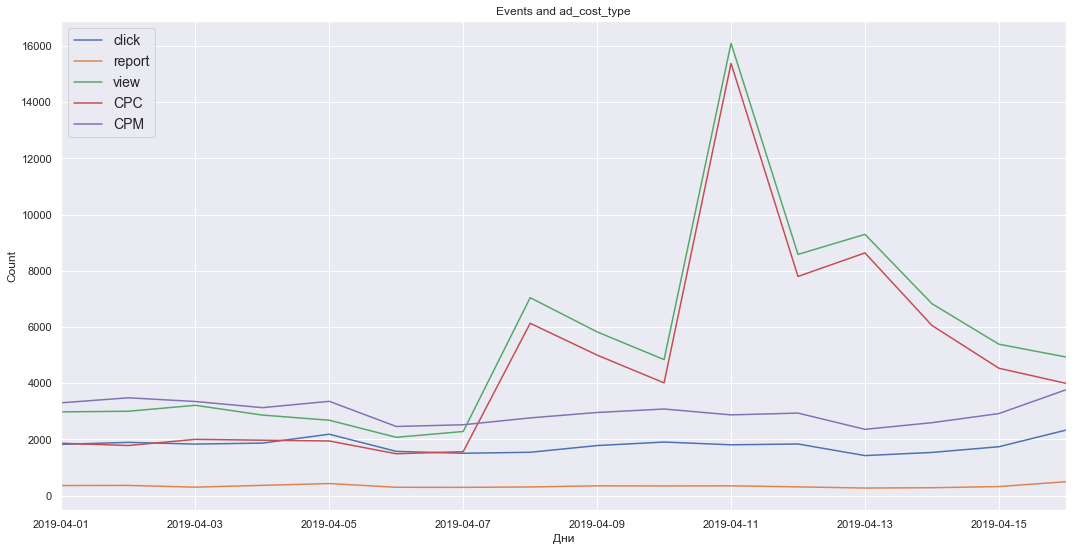

In [25]:
ax = events_data.drop(['android','iphone','mvk','web','wphone'], axis = 1)\
.plot(x = 'date', kind = 'line')

ax.legend(loc=2, prop={'size': 14})
ax.set_title('Events and ad_cost_type')
ax.set_xlabel('Дни')
ax.set_ylabel('Count')

Как видно из таблицы, 11 апреля, количество событий view резко выросло.
Распределение роста по самым популярным платформам составило примерно 2-3 раза.

При этом вместе с ростом количества событий view также выросло значение CPC, понятно, что эти величины взаимосвязаны, но, так, чтобы рост был почти 1 в 1, выглядит несколько странно.

Поэтому посмотрим распределение CPC/CPM к количеству типов событий по дням.

In [26]:
groupped_by_events = df.groupby(['date', 'ad_cost_type', 'event'], as_index=False)\
.agg({'time' : 'count'})\
.rename(columns = {'time' : 'count'})

# request = groupped_by_events.event != 'report'
# groupped_by_events.query(expr='@request', inplace=True)

groupped_by_events["date"] = groupped_by_events["date"].astype("datetime64")

groupped_by_events.head(4)

,date,ad_cost_type,event,count
0,2019-04-01,CPC,click,117
1,2019-04-01,CPC,report,17
2,2019-04-01,CPC,view,1732
3,2019-04-01,CPM,click,1710


Text(0, 0.5, 'Count')

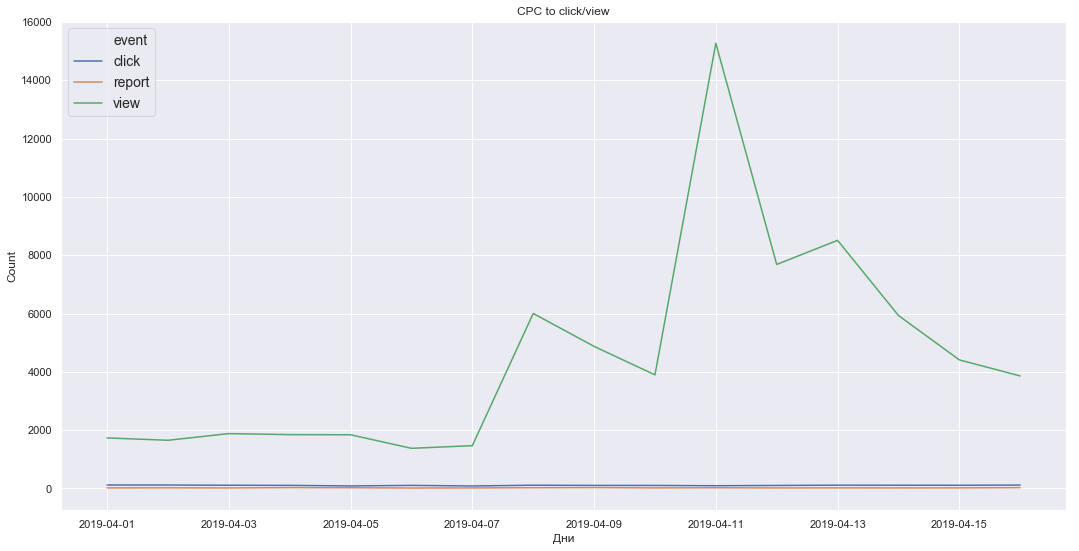

In [27]:
ax = sns.lineplot(x = 'date', y = 'count', hue = 'event', \
             data = groupped_by_events[groupped_by_events.ad_cost_type == 'CPC'].drop('ad_cost_type',axis = 1))
ax.legend(loc=2, prop={'size': 14})
ax.set_title('CPC to click/view')
ax.set_xlabel('Дни')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

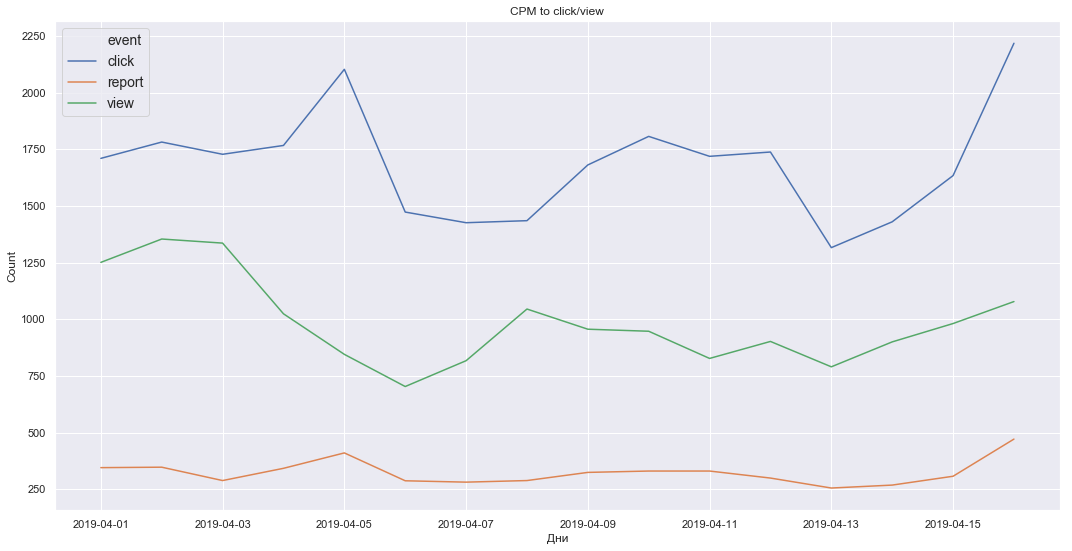

In [28]:
ax = sns.lineplot(x = 'date', y = 'count', hue = 'event', \
                  data = groupped_by_events[groupped_by_events.ad_cost_type == 'CPM'].drop('ad_cost_type',axis = 1))

ax.legend(loc=2, prop={'size': 14})
ax.set_title('CPM to click/view')
ax.set_xlabel('Дни')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

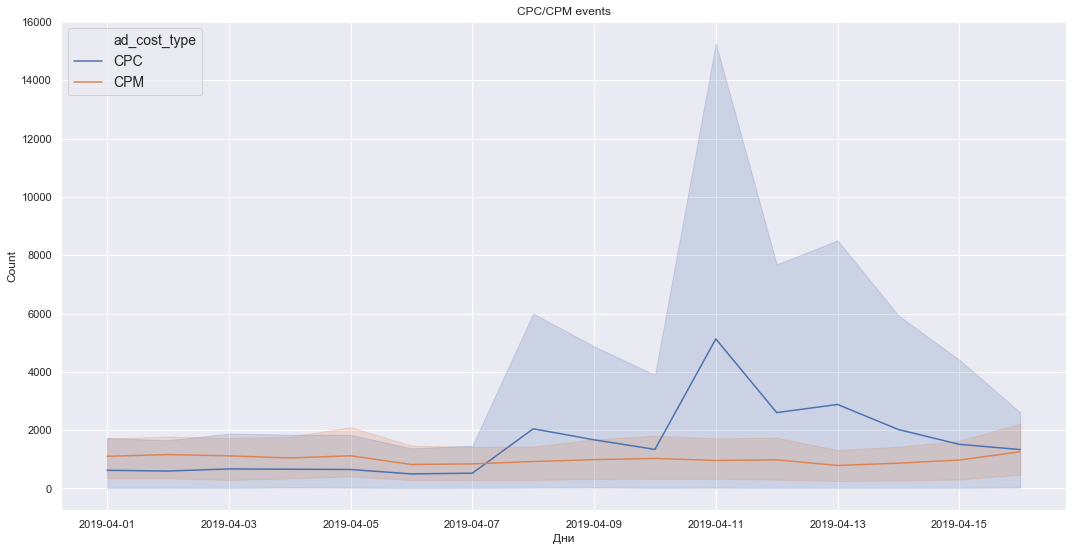

In [29]:
ax = sns.lineplot(x = 'date', y = 'count',hue = 'ad_cost_type' ,data = groupped_by_events)

ax.legend(loc=2, prop={'size': 14})
ax.set_title('CPC/CPM events')
ax.set_xlabel('Дни')
ax.set_ylabel('Count')

Вывод: наибольший вклад дают события типа CPC - view (хотя странно, что кликов при этом относительно мало).

Либо же, события CPC/CPM и click/view поменяны местами (в т.ч. и для агенства_2).

График для CPM больше похож на распределение кликов и просмотров (где вместо кликов - просмотры), тогда как CPC в точности наоборот.

Возможно есть какой-либо сбой по рекламному объявлению, имеющему наиболее количество событий?

Например смена агенства, рекламной кампании или же клиент как-либо изменился?

In [30]:
# пересечение по no_agency - есть agency
df[df.ad_id == 'ad_49554'].head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,time_from_timestamp
11,1555169778,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-13,2019-04-13 15:36:18
14,1555251921,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-14,2019-04-14 14:25:21
19,1555011001,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 19:30:01
20,1555061106,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-12,2019-04-12 09:25:06
22,1554977283,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 10:08:03


In [31]:
for column in df[df.client_union_id == 'client_47270'].drop(['time', 'time_from_timestamp'], axis = 1): 
    print(df[df.client_union_id == 'client_47270'][column].unique())

['view' 'click' 'report']
['CPC']
[False]
['agency_2']
['client_47270']
['campaign_49554']
['ad_49564' 'ad_49554' 'ad_49556' 'ad_49560' 'ad_50872']
['web' 'android' 'mvk' 'iphone']
['2019-04-08' '2019-04-13' '2019-04-14' '2019-04-11' '2019-04-12'
 '2019-04-16' '2019-04-09' '2019-04-15' '2019-04-10' '2019-04-05']


In [32]:
for column in df[df.campaign_union_id == 'campaign_49554'].drop(['time', 'time_from_timestamp'], axis = 1): 
    print(df[df.campaign_union_id == 'campaign_49554'][column].value_counts()[:3])

view      47688
click        45
report        6
Name: event, dtype: int64
CPC    47739
Name: ad_cost_type, dtype: int64
False    47739
Name: has_video, dtype: int64
agency_2    47739
Name: agency_union_id, dtype: int64
client_47270    47739
Name: client_union_id, dtype: int64
campaign_49554    47739
Name: campaign_union_id, dtype: int64
ad_49554    27500
ad_49556     8218
ad_49560     7496
Name: ad_id, dtype: int64
android    34685
iphone      4971
web         4159
Name: platform, dtype: int64
2019-04-11    13941
2019-04-13     7593
2019-04-12     6698
Name: date, dtype: int64


In [33]:
for column in df[df.ad_id == 'ad_49554'].drop(['time', 'time_from_timestamp'], axis = 1): 
    print(df[df.ad_id == 'ad_49554'][column].unique())

['view' 'report' 'click']
['CPC']
[False]
['agency_2']
['client_47270']
['campaign_49554']
['ad_49554']
['android' 'mvk' 'web' 'iphone']
['2019-04-13' '2019-04-14' '2019-04-11' '2019-04-12' '2019-04-16'
 '2019-04-15' '2019-04-10']


In [34]:
for column in df[df.ad_id == 'ad_49554'].drop(['time', 'time_from_timestamp'], axis = 1): 
    print(df[df.ad_id == 'ad_49554'][column].value_counts())

view      27464
click        31
report        5
Name: event, dtype: int64
CPC    27500
Name: ad_cost_type, dtype: int64
False    27500
Name: has_video, dtype: int64
agency_2    27500
Name: agency_union_id, dtype: int64
client_47270    27500
Name: client_union_id, dtype: int64
campaign_49554    27500
Name: campaign_union_id, dtype: int64
ad_49554    27500
Name: ad_id, dtype: int64
android    21042
iphone      2197
mvk         2154
web         2107
Name: platform, dtype: int64
2019-04-11    9640
2019-04-13    6275
2019-04-12    4868
2019-04-14    3693
2019-04-15    2364
2019-04-16     388
2019-04-10     272
Name: date, dtype: int64


Что отдельно стоит отметить, рекламные объявления ad_49554 и ad_49556 проходит по типу трат - CPC и при этом состоит почти полностью из просмотров.

In [35]:
df_uni = df.groupby('ad_id', as_index=False).\
agg({'campaign_union_id' : 'unique',
     'agency_union_id' : 'unique',
     'client_union_id' : 'unique',
    'event' : 'count'})

In [36]:
df_uni.sort_values('event', ascending=False).head(15)

,ad_id,campaign_union_id,agency_union_id,client_union_id,event
17441,ad_49554,[campaign_49554],[agency_2],[client_47270],27500
17442,ad_49556,[campaign_49554],[agency_2],[client_47270],8218
17443,ad_49560,[campaign_49554],[agency_2],[client_47270],7496
17444,ad_49564,[campaign_49554],[agency_2],[client_47270],4491
17414,ad_47269,[campaign_47269],[agency_2],[client_47269],1867
18046,ad_99643,[campaign_99643],[agency_33],[client_99583],577
17545,ad_7701,[campaign_7701],[no_agency],[client_48],559
7324,ad_21831,[campaign_21831],[no_agency],[client_3313],491
11782,ad_387,[campaign_387],[no_agency],[client_6],461
3917,ad_1181,[campaign_1181],[no_agency],[client_7],441


Явно, здесь не видно того, чтобы целостность данных нарушалась, к тому же, данные тоже не расходятся с предыдущими выводами.

#### advertisments and agencies

Также еще не рассматривали рекламные агенства и объявления, в контексте их времени жизни.

Поэтому попробуем посмотреть какие рекламные объявления и в какие дни проигрывались, от какого-либо рекламного агента.

Попробуем построить графики, начала и конца рк, возможно здесь появится ясность.

Чтобы не рассматривать множество мелких групп рассмотрим клиентов без агенств и агенство 2, как имеющее наибольшее количество событий.

In [37]:
# построим графики по другим агенствам/клиентам
df_no_agency = df[df.agency_union_id == 'no_agency'].groupby(['date','ad_id'], as_index=False).\
agg({'event' : 'count'})

df_no_agency['date'] = pd.to_datetime(df_no_agency.date, format='%Y-%m-%d')

df_no_agency.sort_values(by = 'date', ascending=True, inplace=True)

In [38]:
#### drop ad_id, that are less than n in total
# use quantile maybe?
df_no_agency.quantile(.97)

event    8.0
Name: 0.97, dtype: float64

In [39]:
df_no_agency = df_no_agency[df_no_agency.event > 50]

In [40]:
df_no_agency.shape

(27, 3)

In [41]:
df_no_agency.head()

,date,ad_id,event
1435,2019-04-01,ad_7701,197
1403,2019-04-01,ad_5131,53
604,2019-04-01,ad_3024,53
2983,2019-04-02,ad_7701,114
2946,2019-04-02,ad_5132,52


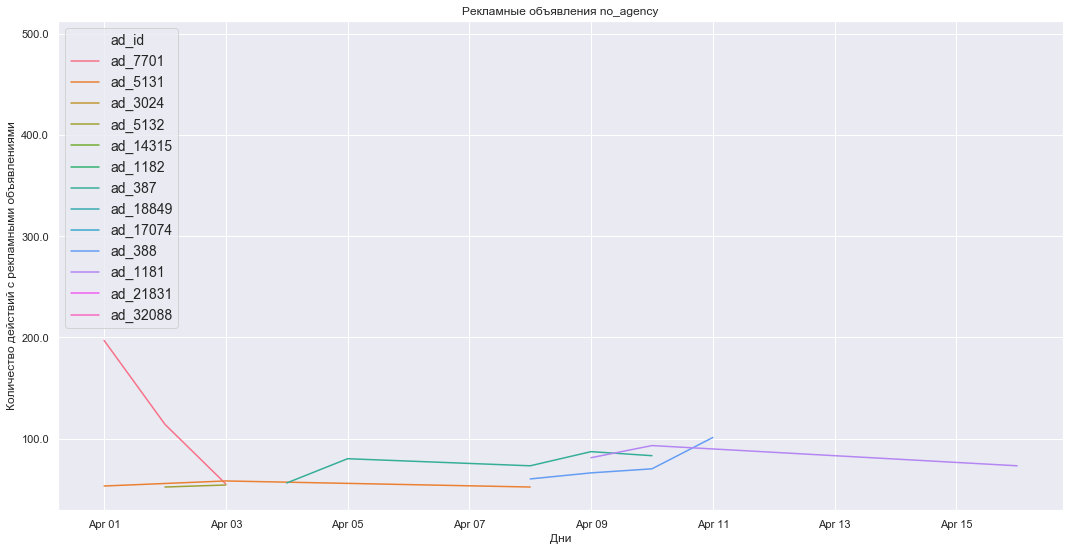

In [42]:
ax = sns.lineplot(x = 'date', y = 'event', hue = 'ad_id', data = df_no_agency)

ax.legend(loc=2, prop={'size': 14})
ax.set_title('Рекламные объявления no_agency')
ax.set_xlabel('Дни')
ax.set_ylabel('Количество действий с рекламными объявлениями')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

ax.yaxis.set_major_formatter(yfmt)

И аналогично для агенства 2.

In [43]:
df_agency_2 = df[df.agency_union_id == 'agency_2'].groupby(['date','ad_id'], as_index=False).\
agg({'event' : 'count'})

df_agency_2['date'] = pd.to_datetime(df_agency_2.date, format='%Y-%m-%d')

df_agency_2.sort_values(by = 'date', ascending=True, inplace=True)

In [44]:
df_agency_2.quantile(.70)

event    145.2
Name: 0.7, dtype: float64

In [45]:
#### drop ad_id, that are less than n in total
# use quantile maybe?
df_agency_2 = df_agency_2[df_agency_2.event > 150]

In [46]:
df_agency_2.head()

,date,ad_id,event
40,2019-04-08,ad_49564,1438
37,2019-04-08,ad_47269,151
39,2019-04-08,ad_49560,2940
46,2019-04-09,ad_49560,1867
47,2019-04-09,ad_49564,1012


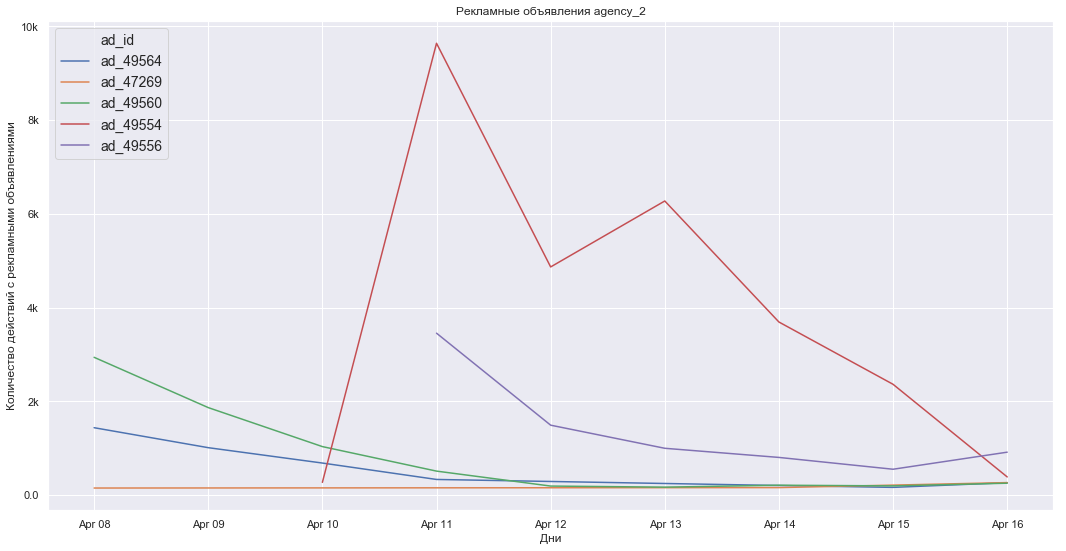

In [47]:
ax = sns.lineplot(x = 'date', y = 'event', hue = 'ad_id', data = df_agency_2)

ax.legend(loc=2, prop={'size': 14})
ax.set_title('Рекламные объявления agency_2')
ax.set_xlabel('Дни')
ax.set_ylabel('Количество действий с рекламными объявлениями')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.yaxis.set_major_formatter(yfmt)

Здесь можно сделать следующие выводы:
- гипотеза о том, что началась рекламная компания, которую посмотрело аномально большое количество пользователей, подтверждается. При этом наибольший эффект дают два объявления, которые в сумме дают наибольший прирост за 11 апреля.

- при этом, аномально мало кликов на объявления на этих двух объявлениях.

Дополнительно попробуем рассчитать параметр CTR для выбранных РК за весь период.

In [48]:
#### ПОСЧИТАТЬ CTR, возможно больше средств влили рекламу

df_ctr = df[df.ad_cost_type == 'CPC'] #df[df.ad_id == 'ad_49554']

df_ctr = df_ctr.groupby(['campaign_union_id','event'], as_index=False).\
agg({'time' : 'count'   
    })

df_ctr.sort_values(['campaign_union_id'], inplace=True)

In [49]:
df_ctr = df_ctr.pivot_table(index='campaign_union_id',
               columns='event',
               #values='campaign_union_id',
               aggfunc='sum').reset_index()

In [50]:
df_ctr.columns = df_ctr.columns.droplevel()
df_ctr.columns = ['campaign_union_id', 'click', 'report', 'view']

In [51]:
#df_ctr[df_ctr.view > 1]

In [52]:
df_ctr['ctr'] = df_ctr.click / df_ctr.view

In [53]:
df_ctr.describe()

,click,report,view,ctr
count,918.000000,234.00000,1109.000000,52.000000
mean,1.821351,1.32906,65.120830,0.172237
std,3.876319,1.26298,1433.937362,0.321167
min,1.000000,1.00000,1.000000,0.000536
25%,1.000000,1.00000,2.000000,0.007288
50%,1.000000,1.00000,4.000000,0.020842
75%,1.000000,1.00000,14.000000,0.125000
max,63.000000,11.00000,47688.000000,1.000000


In [54]:
df_ctr[(df_ctr.click > 1) & (df_ctr.view > 0)].sort_values('ctr', ascending=False)

,campaign_union_id,click,report,view,ctr
1045,campaign_1889,2.0,1.0,19.0,0.105263
1960,campaign_7314,2.0,1.0,26.0,0.076923
2044,campaign_99142,3.0,NaN,59.0,0.050847
1959,campaign_5822,6.0,NaN,1006.0,0.005964
1963,campaign_7701,2.0,NaN,566.0,0.003534
1957,campaign_49554,45.0,6.0,47688.0,0.000944


Похоже, рекламных кампаний (по тратам CPC), которые имели бы и просмотры и клики не так уж и много + campaign_49554 имеет очень низки CTR, что означает либо её низкую эффективность, или малую цену за клик (либо и то и другое сразу).

#### 11 апреля.

Отдельно также рассмотрим день с пиковым количеством событий, а также попробуем понять, как можно детектировать такие аномальные всплески. 

In [55]:
df_splash_day = df[df.date == '2019-04-11']
print (df_splash_day.shape)

(18259, 11)


In [56]:
df_splash_day = df_splash_day.sort_values(by = 'time_from_timestamp')

# дропнем признаки наличие видео и дату как ненужные, видео т.к. оно редко встречается
df_splash_day.drop(['has_video','date'], axis = 1, inplace = True)
df_splash_day.reset_index(inplace=True,drop=True)

In [57]:
df_splash_day.head()

,time,event,ad_cost_type,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,time_from_timestamp
0,1554940810,view,CPC,agency_33,client_99583,campaign_99643,ad_99643,web,2019-04-11 00:00:10
1,1554940815,view,CPM,agency_158,client_106198,campaign_106664,ad_106668,android,2019-04-11 00:00:15
2,1554940818,click,CPC,agency_54647,client_120417,campaign_120517,ad_120534,android,2019-04-11 00:00:18
3,1554940840,view,CPC,no_agency,client_26,campaign_4096,ad_4096,android,2019-04-11 00:00:40
4,1554940847,view,CPC,no_agency,client_2328,campaign_20614,ad_20615,android,2019-04-11 00:00:47


In [58]:
for column in df_splash_day.drop(['time', 'time_from_timestamp'], axis = 1): 
    print(df_splash_day[column].value_counts()[:5])

view      16097
click      1811
report      351
Name: event, dtype: int64
CPC    15383
CPM     2876
Name: ad_cost_type, dtype: int64
agency_2      14035
no_agency      2691
agency_158      105
agency_29        90
agency_33        81
Name: agency_union_id, dtype: int64
client_47270    13941
client_6          143
client_47269       92
client_99239       85
client_42          77
Name: client_union_id, dtype: int64
campaign_49554    13941
campaign_387        143
campaign_47269       79
campaign_99242       73
campaign_5822        62
Name: campaign_union_id, dtype: int64
ad_49554    9640
ad_49556    3455
ad_49560     512
ad_49564     334
ad_388       101
Name: ad_id, dtype: int64
android    12945
iphone      2141
web         1885
mvk         1271
wphone        17
Name: platform, dtype: int64


In [59]:
df_splash_day[df_splash_day.agency_union_id == 'agency_2'].groupby(['ad_cost_type','platform'], as_index=False).\
agg({'event' : 'count'})

,ad_cost_type,platform,event
0,CPC,android,10160
1,CPC,iphone,1501
2,CPC,mvk,1064
3,CPC,web,1308
4,CPM,android,2


Наибольшее количество событий за этот день составляют вида CPC- view, с agency_2, client_47270, campaign_49554, ad_49554 и ad_49556.

Построим таймлайн с распределением событий в течение дня.

In [60]:
df_splash_hour_index = df_splash_day.set_index(df_splash_day.time_from_timestamp.dt.hour)
df_splash_hour_index.head()

,time,event,ad_cost_type,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,time_from_timestamp
time_from_timestamp,,,,,,,,,
0,1554940810,view,CPC,agency_33,client_99583,campaign_99643,ad_99643,web,2019-04-11 00:00:10
0,1554940815,view,CPM,agency_158,client_106198,campaign_106664,ad_106668,android,2019-04-11 00:00:15
0,1554940818,click,CPC,agency_54647,client_120417,campaign_120517,ad_120534,android,2019-04-11 00:00:18
0,1554940840,view,CPC,no_agency,client_26,campaign_4096,ad_4096,android,2019-04-11 00:00:40
0,1554940847,view,CPC,no_agency,client_2328,campaign_20614,ad_20615,android,2019-04-11 00:00:47


Сгруппируем и посмотрим в виде таймлайна на события.

Text(0, 0.5, 'Count')

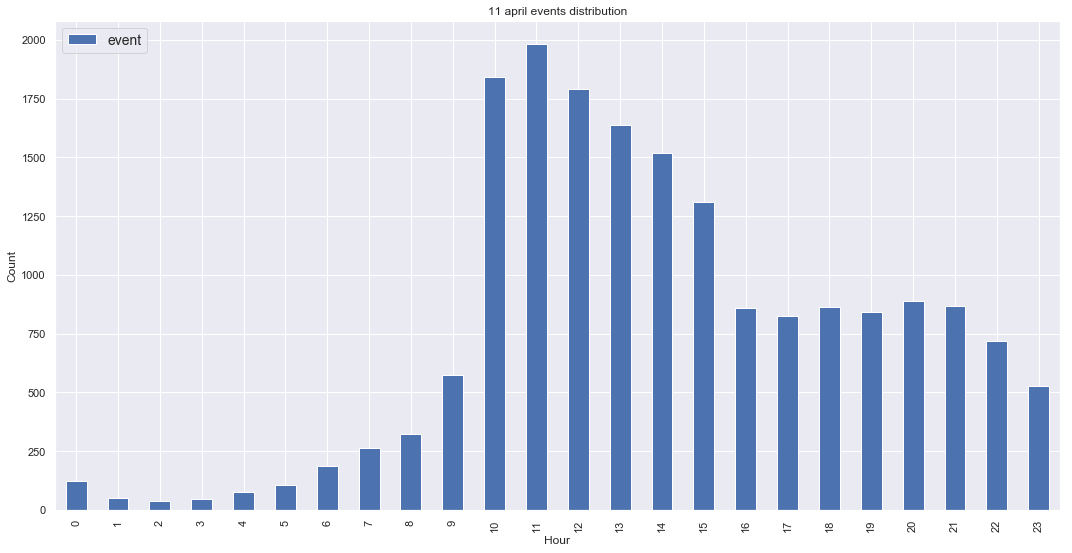

In [61]:
ax = df_splash_hour_index.groupby(df_splash_hour_index.index, as_index=False)\
.agg({'event' : 'count'}).plot(kind = 'bar')

ax.legend(loc=2, prop={'size': 14})
ax.set_title('11 april events distribution')
ax.set_xlabel('Hour')
ax.set_ylabel('Count')

Самыми активными были часы 10:15.

Попробуем выделить паттерны/дубликаты.

Для того, чтобы лучше понять скорость роста, расчитаем разницу между событиями и посчитаем среднее между несколькими событиями используя скользящее окно.

Text(0, 0.5, 'Count')

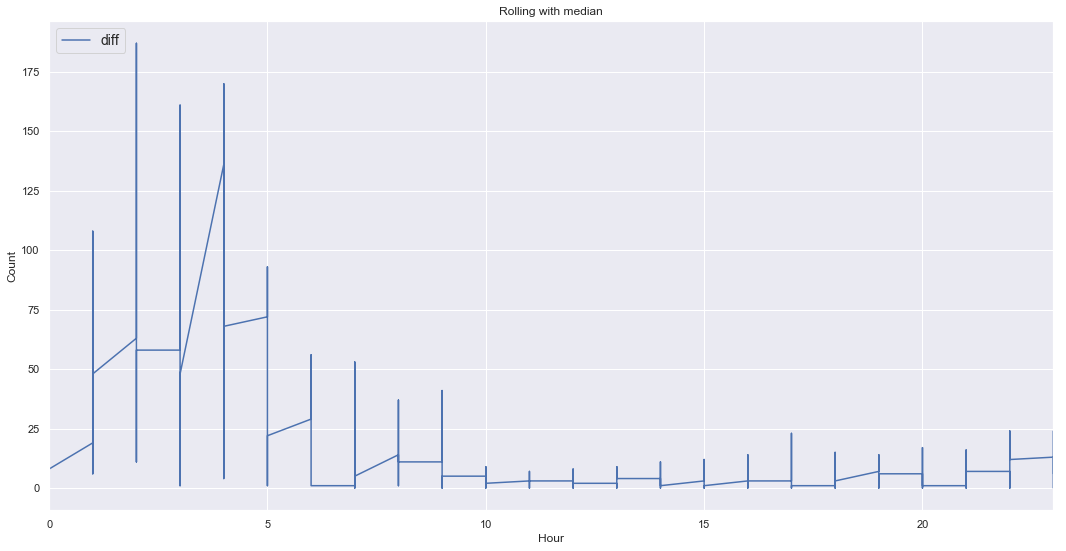

In [62]:
# rolling in pandas?
df_splash_hour_index['diff'] = df_splash_hour_index.time_from_timestamp.diff(periods = 1)
df_splash_hour_index['diff'] = df_splash_hour_index['diff'].astype('timedelta64[s]')

ax = df_splash_hour_index['diff'].rolling(3, min_periods = 1).median().plot(kind = 'line')

ax.legend(loc=2, prop={'size': 14})
ax.set_title('Rolling with median')
ax.set_xlabel('Hour')
ax.set_ylabel('Count')

# try to use 
# df.ewm(alpha=.7).mean().head()
# or
# df.expanding(3).mean().head()

In [63]:
# возможно получится хорошо находить всплески по интервалу в 3 страндартных отклонений
# не помогло, т.к. разброс идет большой
window = 50
df_splash_hour_index['median']= df_splash_hour_index['diff'].rolling(window, 1).mean()
df_splash_hour_index['std'] = df_splash_hour_index['diff'].rolling(window, 1).std()

#filter setup
df_splash_hour_index[(df_splash_hour_index['diff'] <= df_splash_hour_index['median']+3*df_splash_hour_index['std'])\
                     & (df_splash_hour_index['diff'] >= df_splash_hour_index['median']-3*df_splash_hour_index['std'])].head()

,time,event,ad_cost_type,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,time_from_timestamp,diff,median,std
time_from_timestamp,,,,,,,,,,,,
0,1554940818,click,CPC,agency_54647,client_120417,campaign_120517,ad_120534,android,2019-04-11 00:00:18,3.0,4.000000,1.414214
0,1554940840,view,CPC,no_agency,client_26,campaign_4096,ad_4096,android,2019-04-11 00:00:40,22.0,10.000000,10.440307
0,1554940847,view,CPC,no_agency,client_2328,campaign_20614,ad_20615,android,2019-04-11 00:00:47,7.0,9.250000,8.655441
0,1554940853,view,CPC,agency_2,client_47269,campaign_47269,ad_47269,iphone,2019-04-11 00:00:53,6.0,8.600000,7.635444
0,1554940856,click,CPM,agency_158,client_106937,campaign_107611,ad_107611,android,2019-04-11 00:00:56,3.0,7.666667,7.201852


Text(0, 0.5, 'Count')

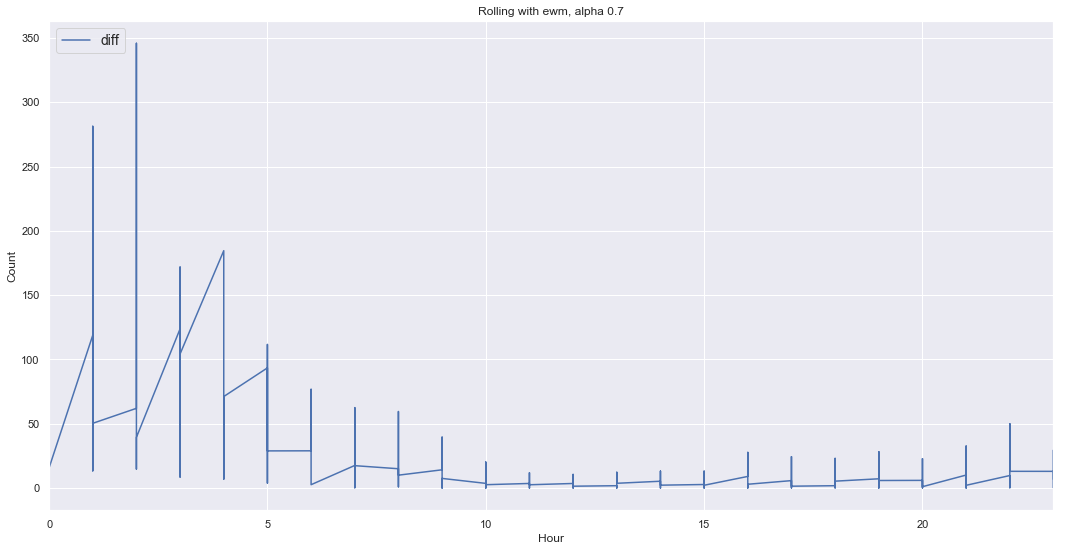

In [64]:
ax = df_splash_hour_index['diff'].ewm(alpha=.7, min_periods = 1).mean().plot(kind = 'line')

ax.legend(loc=2, prop={'size': 14})
ax.set_title('Rolling with ewm, alpha 0.7')
ax.set_xlabel('Hour')
ax.set_ylabel('Count')

Из графиков видно, что наблюдается явный перерыв между часами, что может послужить сигналом к тому, что объявление искусственно прокручивается.

В целом каких-либо новых данных не появилось.

#### Выводы.

После проведенного обзорного исследования данных на предмет причин такого всплеска можно сказать, что такой всплеск количества событий за 11 апреля, в основном, обусловлен двумя рекламными объявлениями проходящим в рамках одной рекламной кампании. Из особенностей следует отметить, что одно из объявлений стартовало на день раньше и "вышло на пик" 11 апреля, в момент старта второго объявления.

Также следует упомянуть, что эти объявления характеризуются очень маленьким количеством кликов при типе трат - CPC.
Возможно, так произошло, потому, что алгоритмы хорошо проранжировали эти объявления, но сами объявления оказались слабоэффективными в рамках неизвестных причин (возможно плохо составлены объявления, некорректая ЦА, и др.).


Альтернативными гипотезами, которые принять не получилось, стали:

- наличие определенного количества дубликатов, которые бы искажали сильно график количества показов объявлений. Проверить это корректно не получилось, т.к. из данных нет возможности получить доказательства уникальности каждого события.
- возможно перепутаны типы трат CPC/CPM и view-click, т.к. в случае такой ошибки графики распределения типов событий от типов трат выглядели бы достаточно правдоподобно.

#### splash detection.

Для того, чтобы предсказывать сплеши можно попробовать использовать:
- скользящее окно и усреднять полученные данные, но такой способ будет слабоэффективен, т.к. по факту мы получим метрику того, что событий происходят с малым интервалом -> большой частотой.

- arima/linear regression. авторегрессия все же выглядит более перспективно, чем модели обычные регрессионные модели, т.к. предполагают лучшую работу с временными последовательностями.

- рекуррентая нейросеть, как вариант LSTM, которая достаточно неплохо зарекомендовала себя для работы с последовательностями.

- основная гипотеза состоит в том, что если значения количества событий отличается от предсказанного моделью (по метрике), то скорее всего стоит обратить внимание на данные.

- также, оптимально добавить еще классификатор, для оценки получения определенного типа события (view, report, click).

По итогу, первым вариантом будет модель arima, в базовом варианте алгоритм работает следующим образом:
- создаем трейн/тест датасеты, которые группируют данные по нужному интервалу времени, доводят датафреймы до требуемой длины

- подготавливаем данные, для использования в arima

- делаем прогноз, далее сравниваем предсказанные значения количества событий с тестовым и считаем метрику rmse

- если метрика превышает выбранный порог, то возвращаем интервалы, где разница между предсказанным и тестовыми значениями больше одного стандартного отклонения.(как вариант использовать среднее + станд. отклонения, если данные буду сильно разниться).


In [65]:
# in current implementation, only 5 min intervals allowed
def create_df(dataset, date, **kwargs):
    groupped_df = dataset[dataset.date == date]
    groupped_df = groupped_df.set_index('time', drop=True)
    groupped_df = groupped_df.sort_values('time', axis = 0)

    groupped_df['date'] = pd.to_datetime(groupped_df.date, format='%Y-%m-%d')    
    
    groupped_df.drop(kwargs['drop_features'], axis = 1, inplace = True)    
    
    # Разбиваем день на интервалы заданной длительности
    groupped_df['time_group'] = (groupped_df.assign(timestamp=groupped_df['time_from_timestamp']\
                                                    .dt.floor(kwargs['interval']))
           .groupby(pd.Grouper(key='time_from_timestamp',freq=kwargs['interval']))
           .ngroup())
    

    groupped_df = groupped_df.groupby('time_group', as_index=False)\
    .agg({'event' : 'count',
          'date' : 'first'})
    
    # дополняем день до требуемого количества интервалов
    # rewrite, to use not custom amount of intervals
    ideal_series = pd.DataFrame(data = np.arange(0,288), columns = ['ideal_timesplit'])
    
    groupped_df = groupped_df.merge(ideal_series,
                                                  how = 'right' ,
                                                  left_on='time_group', 
                                                  right_on='ideal_timesplit')
    
    # заполним пропуски, т.к. они могли появится при доведении дня до нужного количества итервалов
    groupped_df.time_group.fillna(groupped_df['ideal_timesplit'], inplace = True)
    groupped_df.date.fillna(groupped_df.date.iloc[0], inplace = True)
    groupped_df.event.fillna(0, inplace = True)
    
    # добавляем интервалы в отдельную колонку, так удобнее анализировать
    groupped_df['time_period'] = pd.to_datetime((groupped_df.time_group * 5), unit = 'm').dt.strftime('%H:%M')
    
    groupped_df.drop('ideal_timesplit', axis = 1, inplace = True)
    
    groupped_df = groupped_df.sort_values('time_group')

    return groupped_df

In [66]:
# инвертируем разности
def inverse_difference(history, yhat, interval=1):
    # print(history[-interval])
    return yhat + history[-interval]

In [67]:
def check_day(df_train, df_test, threshold):
    # prepare data to use in arima
    train = df_train
    traind_diff = np.array(df_train.event.diff()[1:])
    test = df_test.event

    # fit model
    model = ARIMA(traind_diff, order=(6,0,1))
    model_fit = model.fit(disp=0)

    # predict
    start_index = len(traind_diff)
    end_index = start_index + len(test)-1
    forecast = model_fit.predict(start=start_index, end=end_index)
    # print(start_index, end_index)

    history = train.event.to_list()
    predicts = []

    for yhat in forecast:
        inverted = inverse_difference(history, yhat, 288) # pay attention to 20
        # print('Interval no %d: %f' % (no_interval, inverted)) no_interval+=1
        history.append(inverted)
        predicts.append(inverted)

    df_test['predicts'] = np.round(pd.Series(predicts).astype(int))
    # to look more ordered
    df_test = df_test.reindex(sorted(day_groupped_test.columns), axis=1)
    
    predicts_std = day_groupped_test.predicts.std()
    rmse = np.sqrt(mean_squared_error(df_test.event, df_test.predicts)) 

    # если метрика больше порога, то начинаем смотреть в какой интервал есть наибольшие различия
    if rmse > threshold:

        # выделяем интервалы больше порога, может по среднему от колонки
        results = df_test[(df_test.event-df_test.predicts) > predicts_std]
    else:
        print("anyway look at these data")
        results = df_test[(df_test.event-df_test.predicts) > predicts_std]

    return results, df_test, rmse

In [68]:
# default is 5 min, if we want another interval, need to add more parameters for arima and pass it to dict
dict_args = {'interval' : '5min', 'drop_features' : ['has_video', 'platform']}
day_groupped_train = create_df(df, '2019-04-10', **dict_args)
day_groupped_test = create_df(df, '2019-04-11', **dict_args)

In [69]:
splash_data, result_df, rmse_metric = check_day(day_groupped_train, day_groupped_test, 11)

In [70]:
print(splash_data.head())
width = 2
precision = 4
value = rmse_metric
f"RMSE is: {value:{width}.{precision}}"

          date  event  predicts  time_group time_period
114 2019-04-11     42        24         114       09:30
118 2019-04-11    103        30         118       09:50
119 2019-04-11    173        34         119       09:55
120 2019-04-11     97        25         120       10:00
121 2019-04-11    121        31         121       10:05


'RMSE is: 61.81'

Аналогично попробуем LSTM модель.

In [71]:
# auxiliary function for preparing dateset
# convert sequence to a supervised dataset
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# scale train/test data
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # print(train.shape)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    
    return scaler, train_scaled, test_scaled

# инвертируем обратно значения
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# создаем рекуррентную lstm модель
def fit_lstm(train, test, batch_size, nb_epoch, input_dim):
    x_train, y_train = train[:, 0:-1], train[:, 1]
    x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
    
    x_test, y_test = test[:, 0:-1], test[:, 1]
    x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    model = Sequential()
    model.add(LSTM(input_dim, batch_input_shape=(batch_size, x_train.shape[1], x_train.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()


    earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=2, mode='min',
                                  restore_best_weights=True) # ,min_delta=0.001)
    
    history_model = model.fit(x_train, y_train,                   
                              batch_size=batch_size, 
                              epochs=nb_epoch, 
                              validation_data = (x_test, y_test), 
                              verbose = 0,
                              callbacks=[earlyStopping])
    return model, history_model

In [72]:
def check_day_lstm(df_train, df_test, threshold):
    # prepare data to use in arima
    train_values = df_train.event.values
    train_supervised_values = timeseries_to_supervised(train_values, 1).values

    test_values = df_test.event.values
    test_supervised_values = timeseries_to_supervised(test_values, 1).values

    # transform the scale of the data
    scaler, train_scaled_lstm, test_scaled_lstm = scale(train_supervised_values, test_supervised_values)
    
    # fit the model 
    # dataset, batch,Epoch,Neurons
    lstm_model, model_history = fit_lstm(train_scaled_lstm, test_scaled_lstm, 1, 300 , 4)
    
    # walk-forward validation on the test data
    predictions = np.array([])

    for i in range(len(test_scaled_lstm)):
        #make one-step forecast
        item = test_scaled_lstm[i, 0:-1]
        X = item.reshape(1, 1, len(item))
        yhat = lstm_model.predict(X)
    
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        predictions = np.append(predictions, yhat)

    df_test['predicts'] = np.round(pd.Series(predictions).astype(int))
    # to look more ordered
    df_test = df_test.reindex(sorted(day_groupped_test.columns), axis=1)
    
    predicts_std = day_groupped_test.predicts.std()
    rmse = np.sqrt(mean_squared_error(df_test.event, df_test.predicts)) 

    # если метрика больше порога, то начинаем смотреть в какой интервал есть наибольшие различия
    if rmse > threshold:

        # выделяем интервалы больше порога, может по среднему от колонки
        results = df_test[(df_test.event-df_test.predicts) > predicts_std]
    else:
        print("anyway look at these data")
        results = df_test[(df_test.event-df_test.predicts) > predicts_std]

    return results, df_test, rmse

In [73]:
splash_data, result_df, rmse_metric = check_day_lstm(day_groupped_train, day_groupped_test, 11)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Restoring model weights from the end of the best epoch
Epoch 00137: early stopping


In [74]:
print(splash_data.head())
width = 2
precision = 4
value = rmse_metric
f"RMSE is: {value:{width}.{precision}}"

          date  event  predicts  time_group time_period
118 2019-04-11    103        32         118       09:50
119 2019-04-11    173        72         119       09:55
121 2019-04-11    121        69         121       10:05
122 2019-04-11    181        72         122       10:10
123 2019-04-11    225        76         123       10:15


'RMSE is: 36.91'

Выводы.
Как видно из результатов, LSTM модель работает лучше и дает более точные предсказания (исходя из сравнения по метрике).

Следовательно эта модель должна лучше подойти для того, чтобы прогнозировать всплески.